# # Import Countries.csv and clean the DataFrame

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Replace 'filename.csv' with the path to your CSV file
df = pd.read_csv('countries.csv')

# Display the first few rows of the DataFrame
df.head()

,Country,url,Introduction: Background,Geography: Location,Geography: Geographic coordinates,Geography: Map references,Geography: Area - total,Geography: Area - land,Geography: Area - water,Geography: Area - comparative,...,Transportation: Waterways - note 2,Transportation: Waterways - top ten largest natural lakes (by surface area),Transportation: Waterways - note 3,Transportation: Ports and terminals - top twenty container ports as measured by Twenty-Foot Equivalent Units (TEUs) throughput,Transnational Issues: Refugees and internally displaced persons,Transnational Issues: Trafficking in persons - Tier 2 Watch List,Transnational Issues: Trafficking in persons - Tier 3,Transnational Issues: Illicit drugs - cocaine,Transnational Issues: Illicit drugs - opiates,Energy: Electricity access - population without electricity
0,Afghanistan,https://www.cia.gov/the-world-factbook/countri...,Ahmad Shah DURRANI unified the Pashtun tribes ...,"Southern Asia, north and west of Pakistan, eas...","33 00 N, 65 00 E",Asia,"652,230 sq km","652,230 sq km",0 sq km,almost six times the size of Virginia; slightl...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Akrotiri,https://www.cia.gov/the-world-factbook/countri...,By terms of the 1960 Treaty of Establishment t...,"Eastern Mediterranean, peninsula on the southw...","34 37 N, 32 58 E",Middle East,123 sq km,NaN,NaN,"about 0.7 times the size of Washington, DC",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Albania,https://www.cia.gov/the-world-factbook/countri...,Albania declared its independence from the Ott...,"Southeastern Europe, bordering the Adriatic Se...","41 00 N, 20 00 E",Europe,"28,748 sq km","27,398 sq km","1,350 sq km",slightly smaller than Maryland,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Algeria,https://www.cia.gov/the-world-factbook/countri...,Algeria has known many empires and dynasties s...,"Northern Africa, bordering the Mediterranean S...","28 00 N, 3 00 E",Africa,"2,381,740 sq km","2,381,740 sq km",0 sq km,slightly less than 3.5 times the size of Texas,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,American Samoa,https://www.cia.gov/the-world-factbook/countri...,Tutuila was settled by 1000 B.C. and the islan...,"Oceania, group of islands in the South Pacific...","14 20 S, 170 00 W",Oceania,224 sq km,224 sq km,0 sq km,"slightly larger than Washington, DC",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [2]:
# Clear out unnecessary columns
df = df[['Country', 
                             'People and Society: Population', 
                             'People and Society: Median age - total', 
                             'People and Society: Obesity - adult prevalence rate', 
                             'Economy: Real GDP per capita']]
df

,Country,People and Society: Population,People and Society: Median age - total,People and Society: Obesity - adult prevalence rate,Economy: Real GDP per capita
0,Afghanistan,"38,346,720 (2022 est.)",19.5 years,5.5% (2016),"$1,500 (2021 est.)$2,000 (2020 est.)$2,100 (20..."
1,Akrotiri,"(2020) approximately 18,195 on the Sovereign B...",NaN,NaN,NaN
2,Albania,"3,095,344 (2022 est.)",34.3 years,21.7% (2016),"$14,500 (2021 est.)$13,300 (2020 est.)$13,700 ..."
3,Algeria,"44,178,884 (2022 est.)",28.9 years,27.4% (2016),"$11,000 (2021 est.)$10,800 (2020 est.)$11,600 ..."
4,American Samoa,"45,443 (2022 est.)",27.2 years,NaN,"$11,200 (2016 est.)$11,300 (2015 est.)$11,200 ..."
...,...,...,...,...,...
253,West Bank,"3,000,021 (2022 est.)",21.9 years,NaN,"$5,600 (2021 est.)$5,400 (2020 est.)$6,200 (20..."
254,World,"7,905,336,896 (July 2022 est.)",31 years,NaN,"$17,000 (2021 est.)$16,200 (2020 est.)$16,800 ..."
255,Yemen,"30,984,689 (2022 est.)",19.8 years (2018 est.),17.1% (2016),"$2,500 (2017 est.)$2,700 (2016 est.)$3,200 (20..."
256,Zambia,"19,642,123 (2022 est.)",16.9 years,8.1% (2016),"$3,200 (2021 est.)$3,200 (2020 est.)$3,400 (20..."


In [5]:
# Remove parentheses and everything inside them from the "Economy: Real GDP per capita" column
df['Economy: Real GDP per capita'] = df['Economy: Real GDP per capita'].str.replace(r'\(.*\)', '')


# Split each cell into multiple columns using the "$" character as the separator
df_new = df['Economy: Real GDP per capita'].str.split('$', expand=True)

# Keep only the first column containing the desired data and rename the column
df_new = df_new[[0]].rename(columns={0: 'New_Column_Name'})

# Merge the modified column back into the original dataframe
df = pd.concat([df, df_new], axis=1)

# Remove the final column and show the dataframe
countries_df = df.drop(columns=['New_Column_Name'])

countries_df = countries_df.rename(columns={'People and Society: Obesity - adult prevalence rate': 'Obesity Rate in Adults (2016)'})

countries_df['Obesity Rate in Adults (2016)'] = countries_df['Obesity Rate in Adults (2016)'].str.replace('\s*\(\d{4}\)', '', regex=True)



C:\Users\Micha\AppData\Local\Temp\ipykernel_25612\4236705161.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Economy: Real GDP per capita'] = df['Economy: Real GDP per capita'].str.replace(r'\(.*\)', '')


In [6]:
countries_df

,Country,People and Society: Population,People and Society: Median age - total,Obesity Rate in Adults (2016),Economy: Real GDP per capita
0,Afghanistan,"38,346,720 (2022 est.)",19.5 years,5.5%,"$1,500"
1,Akrotiri,"(2020) approximately 18,195 on the Sovereign B...",NaN,NaN,NaN
2,Albania,"3,095,344 (2022 est.)",34.3 years,21.7%,"$14,500"
3,Algeria,"44,178,884 (2022 est.)",28.9 years,27.4%,"$11,000"
4,American Samoa,"45,443 (2022 est.)",27.2 years,NaN,"$11,200"
...,...,...,...,...,...
253,West Bank,"3,000,021 (2022 est.)",21.9 years,NaN,"$5,600"
254,World,"7,905,336,896 (July 2022 est.)",31 years,NaN,"$17,000"
255,Yemen,"30,984,689 (2022 est.)",19.8 years (2018 est.),17.1%,"$2,500"
256,Zambia,"19,642,123 (2022 est.)",16.9 years,8.1%,"$3,200"


## Bring in World Happiness Report

In [7]:
whr21_df = pd.read_csv('world-happiness-report-2021.csv')

whr21_df

,Country name,Regional indicator,Ladder score,Standard error of ladder score,upperwhisker,lowerwhisker,Logged GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,Ladder score in Dystopia,Explained by: Log GDP per capita,Explained by: Social support,Explained by: Healthy life expectancy,Explained by: Freedom to make life choices,Explained by: Generosity,Explained by: Perceptions of corruption,Dystopia + residual
0,Finland,Western Europe,7.842,0.032,7.904,7.780,10.775,0.954,72.000,0.949,-0.098,0.186,2.43,1.446,1.106,0.741,0.691,0.124,0.481,3.253
1,Denmark,Western Europe,7.620,0.035,7.687,7.552,10.933,0.954,72.700,0.946,0.030,0.179,2.43,1.502,1.108,0.763,0.686,0.208,0.485,2.868
2,Switzerland,Western Europe,7.571,0.036,7.643,7.500,11.117,0.942,74.400,0.919,0.025,0.292,2.43,1.566,1.079,0.816,0.653,0.204,0.413,2.839
3,Iceland,Western Europe,7.554,0.059,7.670,7.438,10.878,0.983,73.000,0.955,0.160,0.673,2.43,1.482,1.172,0.772,0.698,0.293,0.170,2.967
4,Netherlands,Western Europe,7.464,0.027,7.518,7.410,10.932,0.942,72.400,0.913,0.175,0.338,2.43,1.501,1.079,0.753,0.647,0.302,0.384,2.798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,Lesotho,Sub-Saharan Africa,3.512,0.120,3.748,3.276,7.926,0.787,48.700,0.715,-0.131,0.915,2.43,0.451,0.731,0.007,0.405,0.103,0.015,1.800
145,Botswana,Sub-Saharan Africa,3.467,0.074,3.611,3.322,9.782,0.784,59.269,0.824,-0.246,0.801,2.43,1.099,0.724,0.340,0.539,0.027,0.088,0.648
146,Rwanda,Sub-Saharan Africa,3.415,0.068,3.548,3.282,7.676,0.552,61.400,0.897,0.061,0.167,2.43,0.364,0.202,0.407,0.627,0.227,0.493,1.095
147,Zimbabwe,Sub-Saharan Africa,3.145,0.058,3.259,3.030,7.943,0.750,56.201,0.677,-0.047,0.821,2.43,0.457,0.649,0.243,0.359,0.157,0.075,1.205


In [8]:
whr21_df2 = whr21_df[['Country name', 
                      'Healthy life expectancy', 
                      'Ladder score']]

whr21_df2 = whr21_df2.rename(columns={'Country name': 'Country'})

whr21_df2

,Country,Healthy life expectancy,Ladder score
0,Finland,72.000,7.842
1,Denmark,72.700,7.620
2,Switzerland,74.400,7.571
3,Iceland,73.000,7.554
4,Netherlands,72.400,7.464
...,...,...,...
144,Lesotho,48.700,3.512
145,Botswana,59.269,3.467
146,Rwanda,61.400,3.415
147,Zimbabwe,56.201,3.145


## Bring in GymData

In [9]:
gd_df = pd.read_csv('gym_data.csv')

# Display the first few rows of the DataFrame
gd_df.head()

,Country,Total Revenue (USD),Total Number of Gyms,Total Members,Member Penetration Rate,Members Per Gym,Annual Revenue Per Gym,Annual Revenue Per Member
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Denmark,"$427,771,557","1,426","1,098,000",18.90%,769.985975,"$299,980.05",$389.59
2,United Arab Emirates,"$419,100,000",846,"537,313",5.58%,635.121749,"$495,390.07",$779.99
3,Taiwan,"$407,000,000",300,"710,000",2.99%,2366.666667,"$1,356,666.67",$573.24
4,New Zealand,"$405,000,000",690,"650,000",13.60%,942.028985,"$586,956.52",$623.08


In [10]:
gym_data_df = gd_df[['Country', 
                     'Total Number of Gyms', 
                     'Total Members', 
                     'Members Per Gym', 
                     'Annual Revenue Per Member']]

gym_data_df = gym_data_df.dropna()

gym_data_df

,Country,Total Number of Gyms,Total Members,Members Per Gym,Annual Revenue Per Member
1,Denmark,"1,426","1,098,000",769.985975,$389.59
2,United Arab Emirates,846,"537,313",635.121749,$779.99
3,Taiwan,300,"710,000",2366.666667,$573.24
4,New Zealand,690,"650,000",942.028985,$623.08
5,Hong Kong,180,"430,000",2388.888889,$920.93
6,Belgium,900,"882,000",980.000000,$445.64
7,Colombia,"1,752","979,000",558.789954,$384.07
8,Singapore,200,"320,000",1600.000000,"$1,100.00"
9,Ukraine,"1,596","1,270,000",795.739348,$260.12
10,Portugal,"1,100","688,000",625.454545,$475.27


## Bring in AQI_by_city

In [11]:
AQI_city_df = pd.read_csv('AQI_by_city.csv')

AQI_city_df = AQI_city_df.rename(columns={'2021' : '2021 AQI'})

AQI_city_df

,Rank,City,2021 AQI,JAN(2021),FEB(2021),MAR(2021),APR(2021),MAY(2021),JUN(2021),JUL(2021),AUG(2021),SEP(2021),OCT(2021),NOV(2021),DEC(2021),2020,2019,2018,2017
0,1,"Bhiwadi,India",106.2,145.8,129.8,120.2,125.7,86.5,95.9,55.6,55.4,37.1,91.1,188.6,136.6,95.5,83.4,125.4,-
1,2,"Ghaziabad,India",102.0,199.9,172.2,97.8,86.3,52.9,47.2,35.3,37.6,30.8,89.7,218.3,163,106.6,110.2,135.2,144.6
2,3,"Hotan,China",101.5,-,-,158,91.1,167.4,57.4,70.9,93.2,79.3,126.1,111.5,62.6,110.2,110.1,116,91.9
3,4,"Delhi,India",96.4,183.7,142.2,80.5,72.9,47.4,47.1,35.6,36.9,30.2,73.7,224.1,186.4,84.1,98.6,113.5,108.2
4,5,"Jaunpur,India",95.3,182.2,143.5,91,70,51.1,40.7,33.5,34.2,36.8,75.7,196,195.7,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6470,6471,"Mornington,Australia",2.4,2,1.9,2.3,2.1,3.2,3.6,4.3,2.1,2.1,1.7,2,1.9,3.2,3.8,3,3.9
6471,6472,"EmuRiver,Australia",2.1,1.9,1.8,2,2.6,3.4,2.6,1.9,2.1,2.2,1.5,1.4,1.5,2.6,2.5,2.6,2.3
6472,6473,"Judbury,Australia",2.0,1.6,1.5,2.1,1.5,4.1,2,2.2,2.2,1.7,1.5,1.4,1.7,2.4,5.7,2.2,1.9
6473,6474,"StHelens,Australia",1.9,1.8,2.1,2,2.4,2.7,1.6,1.6,1.6,1.9,1.6,2.4,1.6,2.4,2.4,2.9,3.3


In [12]:
split_data = AQI_city_df['City'].str.split(',', expand=True)

AQI_city_df.drop('City', axis=1, inplace=True)

# Insert the new columns into the original DataFrame
AQI_city_df.insert(loc=1, column='City', value=split_data[0])
AQI_city_df.insert(loc=2, column='Country', value=split_data[1])


#Rename Column
AQI_city_df

,Rank,City,Country,2021 AQI,JAN(2021),FEB(2021),MAR(2021),APR(2021),MAY(2021),JUN(2021),JUL(2021),AUG(2021),SEP(2021),OCT(2021),NOV(2021),DEC(2021),2020,2019,2018,2017
0,1,Bhiwadi,India,106.2,145.8,129.8,120.2,125.7,86.5,95.9,55.6,55.4,37.1,91.1,188.6,136.6,95.5,83.4,125.4,-
1,2,Ghaziabad,India,102.0,199.9,172.2,97.8,86.3,52.9,47.2,35.3,37.6,30.8,89.7,218.3,163,106.6,110.2,135.2,144.6
2,3,Hotan,China,101.5,-,-,158,91.1,167.4,57.4,70.9,93.2,79.3,126.1,111.5,62.6,110.2,110.1,116,91.9
3,4,Delhi,India,96.4,183.7,142.2,80.5,72.9,47.4,47.1,35.6,36.9,30.2,73.7,224.1,186.4,84.1,98.6,113.5,108.2
4,5,Jaunpur,India,95.3,182.2,143.5,91,70,51.1,40.7,33.5,34.2,36.8,75.7,196,195.7,-,-,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6470,6471,Mornington,Australia,2.4,2,1.9,2.3,2.1,3.2,3.6,4.3,2.1,2.1,1.7,2,1.9,3.2,3.8,3,3.9
6471,6472,EmuRiver,Australia,2.1,1.9,1.8,2,2.6,3.4,2.6,1.9,2.1,2.2,1.5,1.4,1.5,2.6,2.5,2.6,2.3
6472,6473,Judbury,Australia,2.0,1.6,1.5,2.1,1.5,4.1,2,2.2,2.2,1.7,1.5,1.4,1.7,2.4,5.7,2.2,1.9
6473,6474,StHelens,Australia,1.9,1.8,2.1,2,2.4,2.7,1.6,1.6,1.6,1.9,1.6,2.4,1.6,2.4,2.4,2.9,3.3


In [13]:
AQI_city_df2 = AQI_city_df[['City',
                           'Country', 
                           '2021 AQI', 
                     ]]
AQI_city_df2

,City,Country,2021 AQI
0,Bhiwadi,India,106.2
1,Ghaziabad,India,102.0
2,Hotan,China,101.5
3,Delhi,India,96.4
4,Jaunpur,India,95.3
...,...,...,...
6470,Mornington,Australia,2.4
6471,EmuRiver,Australia,2.1
6472,Judbury,Australia,2.0
6473,StHelens,Australia,1.9


In [14]:
# Compute the average AQI for each country
avg_aqi_by_country = AQI_city_df.groupby(['Country'])['2021 AQI'].mean().reset_index()

# Rename the '2021 AQI' column to 'Average AQI'
avg_aqi_by_country = avg_aqi_by_country.rename(columns={'2021 AQI': 'Average AQI (2021)'})

avg_aqi_by_country

,Country,Average AQI (2021)
0,Afghanistan,37.500000
1,Albania,12.500000
2,Algeria,20.000000
3,Andorra,7.300000
4,Angola,11.000000
...,...,...
113,UnitedArabEmirates,35.350000
114,UnitedKingdom,8.294194
115,Uruguay,14.200000
116,Uzbekistan,42.800000


## Merge the DataFrames

In [15]:
merged_df = pd.merge(gym_data_df, countries_df, on='Country')

merged_df

,Country,Total Number of Gyms,Total Members,Members Per Gym,Annual Revenue Per Member,People and Society: Population,People and Society: Median age - total,Obesity Rate in Adults (2016),Economy: Real GDP per capita
0,Denmark,"1,426","1,098,000",769.985975,$389.59,"5,920,767 (2022 est.)",42 years,19.7%,"$58,000"
1,United Arab Emirates,846,"537,313",635.121749,$779.99,"9,915,803 (2022 est.)",38.4 years,31.7%,"$69,700"
2,Taiwan,300,"710,000",2366.666667,$573.24,"23,580,712 (2022 est.)",42.3 years,NaN,"$24,502"
3,New Zealand,690,"650,000",942.028985,$623.08,"5,053,004 (2022 est.)",37.2 years,30.8%,"$42,900"
4,Hong Kong,180,"430,000",2388.888889,$920.93,"7,276,588 (2022 est.)",45.6 years,NaN,"$60,000"
5,Belgium,900,"882,000",980.000000,$445.64,"11,847,338 (2022 est.)",41.6 years,22.1%,"$51,700"
6,Colombia,"1,752","979,000",558.789954,$384.07,"49,059,221 (2022 est.)",31.2 years,22.3%,"$14,600"
7,Singapore,200,"320,000",1600.000000,"$1,100.00","5,921,231 (2022 est.)",35.6 years,6.1%,"$106,000"
8,Ukraine,"1,596","1,270,000",795.739348,$260.12,"43,528,136 (2022 est.)",41.2 years,24.1%,"$12,900"
9,Portugal,"1,100","688,000",625.454545,$475.27,"10,242,081 (2022 est.)",44.6 years,20.8%,"$33,700"


In [16]:
merged_df2 = pd.merge(merged_df, whr21_df2, on='Country')

merged_df2 = merged_df2.rename(columns={'Ladder score': 'World Happiness Score'})

merged_df2

,Country,Total Number of Gyms,Total Members,Members Per Gym,Annual Revenue Per Member,People and Society: Population,People and Society: Median age - total,Obesity Rate in Adults (2016),Economy: Real GDP per capita,Healthy life expectancy,World Happiness Score
0,Denmark,"1,426","1,098,000",769.985975,$389.59,"5,920,767 (2022 est.)",42 years,19.7%,"$58,000",72.700,7.620
1,United Arab Emirates,846,"537,313",635.121749,$779.99,"9,915,803 (2022 est.)",38.4 years,31.7%,"$69,700",67.333,6.561
2,New Zealand,690,"650,000",942.028985,$623.08,"5,053,004 (2022 est.)",37.2 years,30.8%,"$42,900",73.400,7.277
3,Belgium,900,"882,000",980.000000,$445.64,"11,847,338 (2022 est.)",41.6 years,22.1%,"$51,700",72.199,6.834
4,Colombia,"1,752","979,000",558.789954,$384.07,"49,059,221 (2022 est.)",31.2 years,22.3%,"$14,600",68.001,6.012
5,Singapore,200,"320,000",1600.000000,"$1,100.00","5,921,231 (2022 est.)",35.6 years,6.1%,"$106,000",76.953,6.377
6,Ukraine,"1,596","1,270,000",795.739348,$260.12,"43,528,136 (2022 est.)",41.2 years,24.1%,"$12,900",64.902,4.875
7,Portugal,"1,100","688,000",625.454545,$475.27,"10,242,081 (2022 est.)",44.6 years,20.8%,"$33,700",72.600,5.929
8,Ireland,720,"515,000",715.277778,$624.06,"5,275,004 (2022 est.)",37.8 years,25.3%,"$102,500",72.400,7.085
9,Indonesia,370,"470,000",1270.270270,$576.60,"277,329,163 (2022 est.)",31.1 years,6.9%,"$11,900",62.236,5.345


In [17]:
merged_df3 = merged_df2.merge(avg_aqi_by_country, on='Country', how='left')

merged_df3

,Country,Total Number of Gyms,Total Members,Members Per Gym,Annual Revenue Per Member,People and Society: Population,People and Society: Median age - total,Obesity Rate in Adults (2016),Economy: Real GDP per capita,Healthy life expectancy,World Happiness Score,Average AQI (2021)
0,Denmark,"1,426","1,098,000",769.985975,$389.59,"5,920,767 (2022 est.)",42 years,19.7%,"$58,000",72.700,7.620,9.700000
1,United Arab Emirates,846,"537,313",635.121749,$779.99,"9,915,803 (2022 est.)",38.4 years,31.7%,"$69,700",67.333,6.561,NaN
2,New Zealand,690,"650,000",942.028985,$623.08,"5,053,004 (2022 est.)",37.2 years,30.8%,"$42,900",73.400,7.277,NaN
3,Belgium,900,"882,000",980.000000,$445.64,"11,847,338 (2022 est.)",41.6 years,22.1%,"$51,700",72.199,6.834,11.552727
4,Colombia,"1,752","979,000",558.789954,$384.07,"49,059,221 (2022 est.)",31.2 years,22.3%,"$14,600",68.001,6.012,12.875000
5,Singapore,200,"320,000",1600.000000,"$1,100.00","5,921,231 (2022 est.)",35.6 years,6.1%,"$106,000",76.953,6.377,13.800000
6,Ukraine,"1,596","1,270,000",795.739348,$260.12,"43,528,136 (2022 est.)",41.2 years,24.1%,"$12,900",64.902,4.875,17.266667
7,Portugal,"1,100","688,000",625.454545,$475.27,"10,242,081 (2022 est.)",44.6 years,20.8%,"$33,700",72.600,5.929,7.040000
8,Ireland,720,"515,000",715.277778,$624.06,"5,275,004 (2022 est.)",37.8 years,25.3%,"$102,500",72.400,7.085,8.636842
9,Indonesia,370,"470,000",1270.270270,$576.60,"277,329,163 (2022 est.)",31.1 years,6.9%,"$11,900",62.236,5.345,18.903704


## Begin Visualizations - 1st) Does the environment of a country affect their fitness levels?

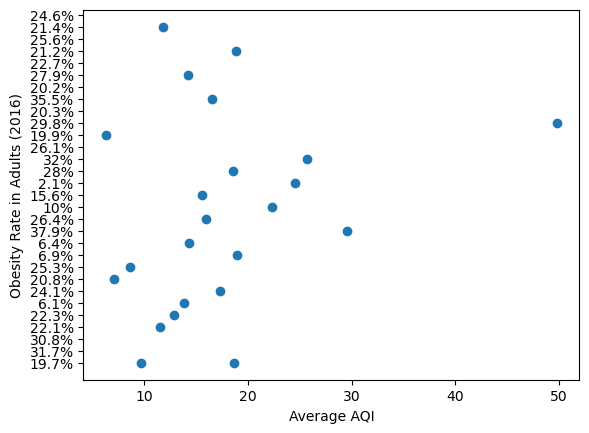

In [20]:
# Create a Scatter Plot of AQI vs Obesity Rate in Adults
plt.scatter(merged_df3['Average AQI (2021)'], merged_df3['Obesity Rate in Adults (2016)'])
plt.xlabel('Average AQI')
plt.ylabel('Obesity Rate in Adults (2016)')
plt.show()

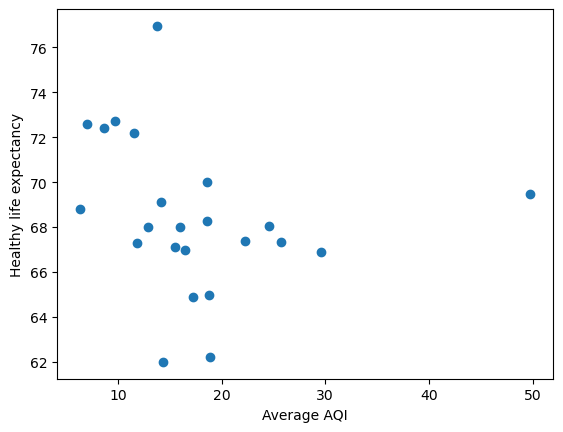

In [21]:
# Create a Scatter plot of AQI vs Healthy life expectancy
plt.scatter(merged_df3['Average AQI (2021)'], merged_df3['Healthy life expectancy'])
plt.xlabel('Average AQI')
plt.ylabel('Healthy life expectancy')
plt.show()


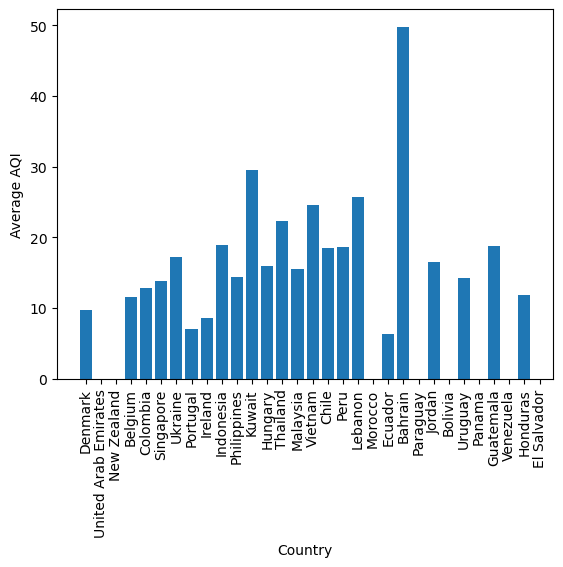

In [22]:
# Bar Chart of AQI by Country
plt.bar(merged_df3['Country'], merged_df3['Average AQI (2021)'])
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('Average AQI')
plt.show()

TypeError: cannot perform reduce with flexible type

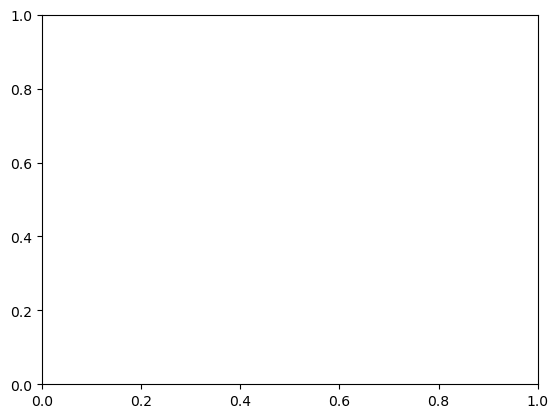

In [24]:
#STILL WORKING ON THIS ONE
# Box plot of Obesity Rate in Adults by AQI 
# Group the data by AQI
grouped_data = merged_df3.groupby('Average AQI (2021)')['Obesity Rate in Adults (2016)'].apply(list)

# Create a list of lists for the box plot
data_for_boxplot = [grouped_data[aqi] for aqi in sorted(grouped_data.keys())]

# Create the box plot
plt.boxplot(data_for_boxplot, labels=sorted(grouped_data.keys()))

# Set the axis labels
plt.xlabel('Average AQI')
plt.ylabel('Obesity Rate in Adults (2016)')

# Show the plot
plt.show()